step -1: Load and Explore the Data



In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/cleaned_reviews.csv'
df = pd.read_csv(file_path)

# Display basic information about the dataset
print(df.info())
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17340 entries, 0 to 17339
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   sentiments             17340 non-null  object
 1   cleaned_review         17337 non-null  object
 2   cleaned_review_length  17340 non-null  int64 
 3   review_score           17340 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 542.0+ KB
None
Index(['sentiments', 'cleaned_review', 'cleaned_review_length',
       'review_score'],
      dtype='object')


Step 2: Data Cleaning and Preprocessing

In [ ]:
import re
print("Missing values in each column:\n", df.isnull().sum())

df.dropna(inplace=True)

# Check for duplicate rows and drop them
df.drop_duplicates(inplace=True)

# Basic text cleaning function
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply text cleaning to the 'cleaned_review' column
df['cleaned_review'] = df['cleaned_review'].apply(clean_text)

print(df.head())


Missing values in each column:
 sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64
  sentiments                                     cleaned_review  \
0   positive  i wish would have gotten one earlier love it a...   
1    neutral  i ve learned this lesson again open the packag...   
2    neutral          it is so slow and lags find better option   
3    neutral  roller ball stopped working within months of m...   
4    neutral  i like the color and size but it few days out ...   

   cleaned_review_length  review_score  
0                     19             5  
1                     88             1  
2                      9             2  
3                     12             1  
4                     21             1  


Step 3: Text Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(df['cleaned_review'])
print(X.shape)


(15990, 9577)


Step 4: Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiments'])
print(label_encoder.classes_)
print(y[:10])


['negative' 'neutral' 'positive']
[2 1 1 1 1 2 1 2 0 0]


Step 5: Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)


(12792, 9577) (3198, 9577)


In [ ]:
# from sklearn.svm import SVC
# from sklearn.metrics import classification_report, accuracy_score
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid for GridSearch
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'gamma': [1, 0.1, 0.01, 0.001],
#     'kernel': ['linear', 'rbf']
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5)

# # Fit GridSearchCV to the data
# grid_search.fit(X_train, y_train)

# # Best estimator
# best_svm_model = grid_search.best_estimator_

# # Predictions and evaluation
# y_pred_svm = best_svm_model.predict(X_test)
# svm_accuracy = accuracy_score(y_test, y_pred_svm)
# svm_report = classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_)

# print(f"SVM Best Model Accuracy: {svm_accuracy}")
# print("SVM Best Model Classification Report:\n", svm_report)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['cleaned_review'])
X_sequences = tokenizer.texts_to_sequences(df['cleaned_review'])

# Padding sequences
X_padded = pad_sequences(X_sequences, maxlen=300)

# Label encoding and one-hot encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiments'])  # Replace with your actual label column
y_categorical = to_categorical(y, num_classes=3)  # Adjust the num_classes if needed

# Train-test split
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

# Build the RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=10000, output_dim=128))
rnn_model.add(SpatialDropout1D(0.2))
rnn_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))  # Corrected line
rnn_model.add(Dense(3, activation='softmax'))  # Adjust the number of classes

rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
rnn_model.fit(X_train_rnn, y_train_rnn, epochs=5, batch_size=64, validation_data=(X_test_rnn, y_test_rnn), verbose=2)

# Evaluate the model
rnn_score, rnn_accuracy = rnn_model.evaluate(X_test_rnn, y_test_rnn, verbose=0)
print(f"RNN Model Accuracy: {rnn_accuracy}")


Epoch 1/5
200/200 - 121s - 605ms/step - accuracy: 0.7124 - loss: 0.6598 - val_accuracy: 0.8114 - val_loss: 0.4625
Epoch 2/5
200/200 - 143s - 713ms/step - accuracy: 0.8392 - loss: 0.4110 - val_accuracy: 0.8580 - val_loss: 0.3874
Epoch 3/5
200/200 - 125s - 623ms/step - accuracy: 0.8792 - loss: 0.3251 - val_accuracy: 0.8605 - val_loss: 0.3735
Epoch 4/5
200/200 - 141s - 705ms/step - accuracy: 0.9074 - loss: 0.2568 - val_accuracy: 0.8715 - val_loss: 0.3585
Epoch 5/5
200/200 - 162s - 812ms/step - accuracy: 0.9242 - loss: 0.2142 - val_accuracy: 0.8749 - val_loss: 0.3641
RNN Model Accuracy: 0.8749217987060547


In [ ]:
import joblib

# Save the best model (example: RNN)
# rnn_model.save('best_rnn_model.h5')
rnn_model.save('best_rnn_model.keras')


# Save the tokenizer for the RNN model
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


Load and Use the Model for Predictions

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved RNN model
rnn_model = load_model('best_rnn_model.keras')
# Make Predictions on New Data
new_text = ["This is a new sample review for prediction"]
new_sequences = tokenizer.texts_to_sequences(new_text)
new_padded = pad_sequences(new_sequences, maxlen=300)

prediction = rnn_model.predict(new_padded)
predicted_class = prediction.argmax(axis=1)

# Convert the predicted class index back to the original label
predicted_label = label_encoder.inverse_transform(predicted_class)
print(f"Predicted Label: {predicted_label[0]}")
#  Evaluate Model on Test Data
rnn_score, rnn_accuracy = rnn_model.evaluate(X_test_rnn, y_test_rnn, verbose=0)
print(f"RNN Model Accuracy: {rnn_accuracy}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Predicted Label: neutral


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


200/200 - 131s - 654ms/step - accuracy: 0.7094 - loss: 0.6645 - val_accuracy: 0.8183 - val_loss: 0.4600
Epoch 2/5
200/200 - 131s - 657ms/step - accuracy: 0.8361 - loss: 0.4153 - val_accuracy: 0.8483 - val_loss: 0.3898
Epoch 3/5
200/200 - 142s - 708ms/step - accuracy: 0.8848 - loss: 0.3135 - val_accuracy: 0.8505 - val_loss: 0.3948
Epoch 4/5
200/200 - 141s - 704ms/step - accuracy: 0.9099 - loss: 0.2537 - val_accuracy: 0.8674 - val_loss: 0.3735
Epoch 5/5
200/200 - 142s - 710ms/step - accuracy: 0.9279 - loss: 0.2037 - val_accuracy: 0.8649 - val_loss: 0.3772


RNN Model Accuracy: 0.8649155497550964
Model saved to rnn_model.h5


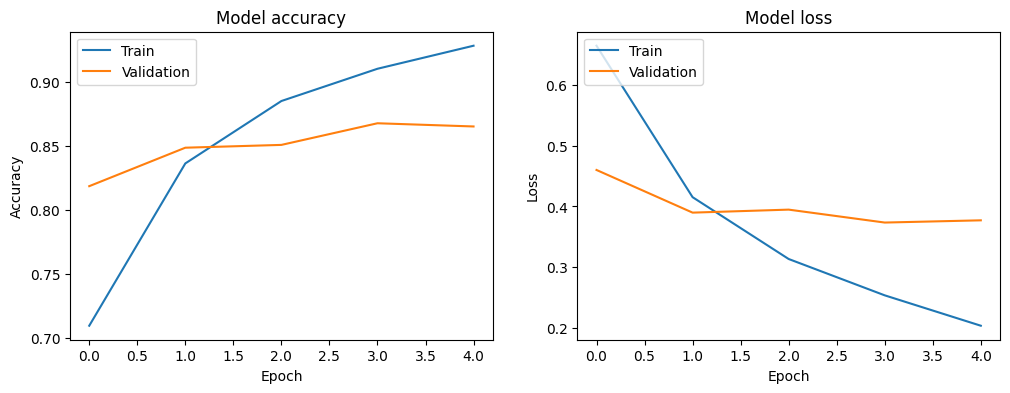

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Assuming df['cleaned_review'] contains the text data and df['label_column'] contains the labels

# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['cleaned_review'])
X_sequences = tokenizer.texts_to_sequences(df['cleaned_review'])

# Padding sequences
X_padded = pad_sequences(X_sequences, maxlen=300)

# Label encoding and one-hot encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiments'])  # Replace with your actual label column
# y_categorical = to_categorical(y, num_classes=3)  # Adjust num_classes if you have more/less classes
print("Encoded labels:", label_encoder.classes_)
print("Number of encoded classes:", len(label_encoder.classes_))
print("Encoded class names:", label_encoder.classes_)

# Train-test split
from sklearn.model_selection import train_test_split

X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

# Build the RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=10000, output_dim=128, input_length=300))
rnn_model.add(SpatialDropout1D(0.2))
rnn_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
rnn_model.add(Dense(3, activation='softmax'))  # Adjust the number of classes if needed

rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = rnn_model.fit(X_train_rnn, y_train_rnn, epochs=5, batch_size=64, validation_data=(X_test_rnn, y_test_rnn), verbose=2)

rnn_score, rnn_accuracy = rnn_model.evaluate(X_test_rnn, y_test_rnn, verbose=0)
print(f"RNN Model Accuracy: {rnn_accuracy}")

rnn_model.save('rnn_model.h5')
print("Model saved to rnn_model.h5")

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()






Evaluate the Model with Additional Metrics

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.preprocessing import LabelEncoder


# Generate predictions on the test set
y_pred_rnn = rnn_model.predict(X_test_rnn).argmax(axis=1)  # Get the predicted class labels
y_true = y_test_rnn.argmax(axis=1)  # True class labels

# Check the number of classes in the label encoder
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")

# Generate the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_rnn, target_names=label_encoder.classes_[:num_classes]))


# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_rnn)
print("Confusion Matrix:")
print(conf_matrix)


100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step
Number of classes: 3
Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.62      0.67       266
     neutral       0.81      0.85      0.83      1146
    positive       0.92      0.91      0.92      1786

    accuracy                           0.86      3198
   macro avg       0.82      0.80      0.80      3198
weighted avg       0.87      0.86      0.86      3198

Confusion Matrix:
[[ 166   84   16]
 [  53  977  116]
 [  11  152 1623]]


Visualize the Confusion Matrix

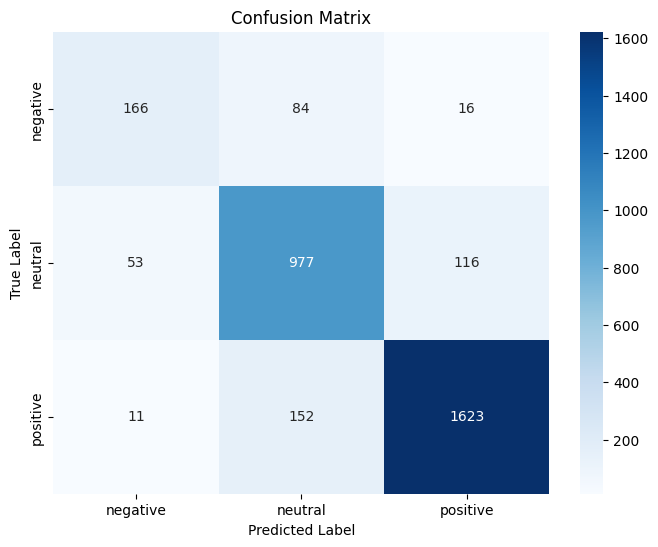

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Visualize the Training Process

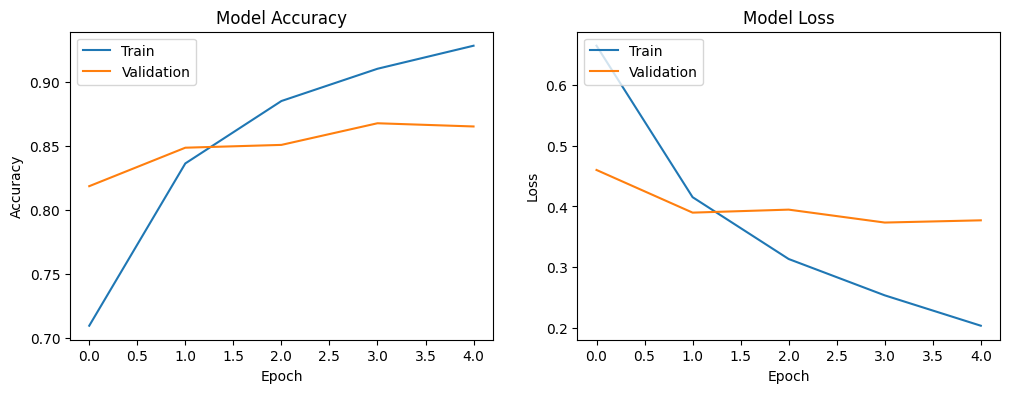

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
# Check the original labels in your DataFrame
print("Unique labels in the original data:")
print(df['sentiments'].unique())


Unique labels in the original data:
['positive' 'neutral' 'negative']


Model Improvement Strategies

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming df is your DataFrame with a 'label_column' containing the original labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiments'])  # y now contains encoded labels

# Now split the data
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# y_train_rnn contains the original encoded labels
from sklearn.utils import class_weight

# Compute class weights based on the original labels
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_rnn), y=y_train_rnn)
class_weights_dict = dict(enumerate(class_weights))

# Display class weights for debugging
print("Class Weights:", class_weights_dict)
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
y_train_rnn_categorical = to_categorical(y_train_rnn, num_classes=3)  # Assuming 3 classes
y_test_rnn_categorical = to_categorical(y_test_rnn, num_classes=3)  # Assuming 3 classes
# Train the model with class weights
rnn_model.fit(X_train_rnn, y_train_rnn_categorical, epochs=5, batch_size=64,
              validation_data=(X_test_rnn, y_test_rnn_categorical),
              class_weight=class_weights_dict, verbose=2)



Class Weights: {0: 3.663230240549828, 1: 0.9241439098396186, 2: 0.607927003136584}
Epoch 1/5
200/200 - 134s - 669ms/step - accuracy: 0.9220 - loss: 0.2379 - val_accuracy: 0.8155 - val_loss: 0.5435
Epoch 2/5
200/200 - 127s - 634ms/step - accuracy: 0.9146 - loss: 0.2296 - val_accuracy: 0.8593 - val_loss: 0.4236
Epoch 3/5
200/200 - 143s - 716ms/step - accuracy: 0.9422 - loss: 0.1629 - val_accuracy: 0.8724 - val_loss: 0.3995
Epoch 4/5
200/200 - 139s - 695ms/step - accuracy: 0.9533 - loss: 0.1317 - val_accuracy: 0.8721 - val_loss: 0.4390
Epoch 5/5
200/200 - 144s - 718ms/step - accuracy: 0.9561 - loss: 0.1219 - val_accuracy: 0.8712 - val_loss: 0.4346


RNN Model Accuracy: 0.8712
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step
Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.74      0.70       266
     neutral       0.83      0.83      0.83      1146
    positive       0.93      0.92      0.92      1786

    accuracy                           0.87      3198
   macro avg       0.81      0.83      0.82      3198
weighted avg       0.87      0.87      0.87      3198



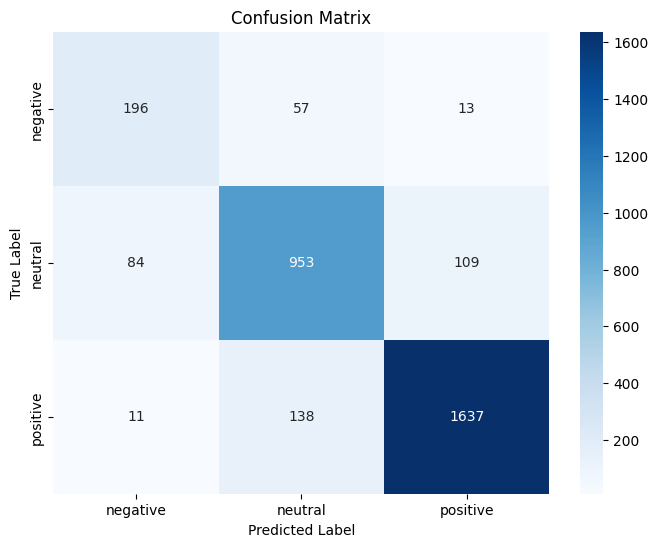

In [ ]:
# Evaluate the model
rnn_score, rnn_accuracy = rnn_model.evaluate(X_test_rnn, y_test_rnn_categorical, verbose=0)
print(f"RNN Model Accuracy: {rnn_accuracy:.4f}")

# Generate predictions
y_pred_rnn = rnn_model.predict(X_test_rnn)

# Convert predictions from probabilities to class labels
y_pred_labels = np.argmax(y_pred_rnn, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

# Generate classification report
print("Classification Report:")
print(classification_report(y_test_rnn, y_pred_labels, target_names=label_encoder.classes_))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_rnn, y_pred_labels)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()





save the Model:

In [35]:
# Save the model
rnn_model.save('rnn_model.keras')

# Save the tokenizer and label encoder
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)


In [36]:
pip install flask
